# Fully Convolutional Neural Networks (FCNNs) - Denoising Example



In [1]:
# Import additional libraries if you need
%matplotlib inline
import numpy as np
import matplotlib.pylab as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

## Denoising FCNN

Develop a FCNN model that receives as input 20 1-dimensional noisy measurements of the same signal and outputs the denoised signal.

- Data download link: https://drive.google.com/file/d/1O811Dsz8e_R2zfXVoeXMG2ZeayBUdoVn/view?usp=sharing


### 2.1 Load data  and split into train, validation, test

In [2]:
# Loading the data
data = np.load("../Data/denoising-1d/noisy_transients.npy")
target = np.load("../Data/denoising-1d/reference.npy")


# Shuffle the samples
indexes = np.arange(data.shape[0], dtype = int)
np.random.shuffle(indexes)
data = data[indexes]
target = target[indexes]


# Splitting the data into train/val/test
X_train = data[:int(data.shape[0]*0.8)]
Y_train = target[:int(data.shape[0]*0.8)]

X_val = data[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]
Y_val = target[int(data.shape[0]*0.8):int(data.shape[0]*0.9)]

X_test = data[int(data.shape[0]*0.9):]
Y_test = target[int(data.shape[0]*0.9):]

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(216, 256, 20)
(27, 256, 20)
(27, 256, 20)


### 2.2. Explore your data

In [3]:
print(X_train.min(),X_train.max(),X_train.mean(),X_train.std())

-2.9169581831740183 3.7456143553633217 0.20379700572375595 0.7244615523299689


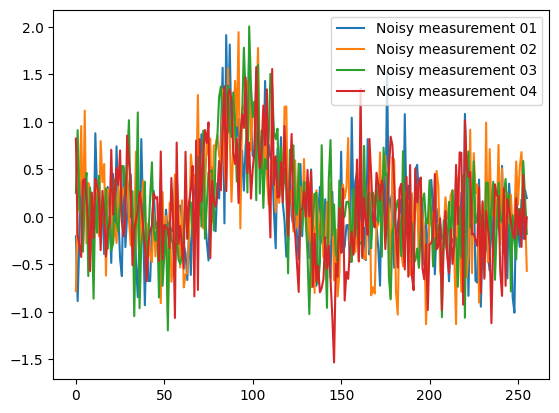

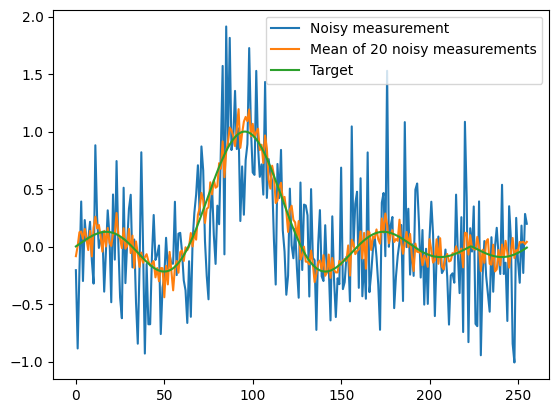

In [4]:
plt.figure()
plt.plot(X_train[0,:,0], label = "Noisy measurement 01")
plt.plot(X_train[0,:,1], label = "Noisy measurement 02")
plt.plot(X_train[0,:,2], label = "Noisy measurement 03")
plt.plot(X_train[0,:,3], label = "Noisy measurement 04")
plt.legend()
plt.show()

plt.figure()
plt.plot(X_train[0,:,0], label = "Noisy measurement")
plt.plot(X_train[0,:,:].mean(axis = -1), label = "Mean of 20 noisy measurements")
plt.plot(Y_train[0,:], label = "Target")
plt.legend()
plt.show()

### 2.3. Data scaling and Data augmentation

In [5]:
mean_train, std_train = X_train.mean(), X_train.std()

Xtrain_norm = (X_train - mean_train)/std_train 
Ytrain_norm = (Y_train - mean_train)/std_train

Xval_norm = (X_val - mean_train)/std_train
Yval_norm = (Y_val - mean_train)/std_train

Xtest_norm = (X_test - mean_train)/std_train
Ytest_norm = (Y_test - mean_train)/std_train

In [6]:
print(Xtrain_norm.min(),Xtrain_norm.max(),Xtrain_norm.mean(),Xtrain_norm.std())

-4.30768917806748 4.888896226788833 -9.86864910777917e-18 1.0


### 2.4. Define your  model

In [7]:
class Fcnn_1d(nn.Module):
    
    def __init__(self, in_channels = 20):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels = in_channels, out_channels=60, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(in_channels=60, out_channels=60, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(in_channels=60, out_channels=60, kernel_size=3, padding=1)
        self.conv4 = nn.Conv1d(in_channels=60, out_channels=60, kernel_size=3, padding=1)
        self.out = nn.Conv1d(in_channels=60, out_channels=1, kernel_size=1, padding=0) 
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.out(x)
        return x


fcnn = Fcnn_1d()
fcnn


Fcnn_1d(
  (conv1): Conv1d(20, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv3): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  (out): Conv1d(60, 1, kernel_size=(1,), stride=(1,))
)

In [8]:
class UnetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, padding=1)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, padding=1)
        
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        return x


class Unet_1d(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoding path
        self.block1 = UnetBlock(20, 60, 3)
        self.block2 = UnetBlock(60, 120, 3)
        self.block3 = UnetBlock(120, 240, 3)
        
        # Decoder Path
        self.block4 = UnetBlock(360, 120, 3)
        self.block5 = UnetBlock(180, 60, 3)
        self.out = nn.Conv1d(60, 1, 1)
    
    def forward(self, x):
        # Nx20x256
        out1 = self.block1(x)  # Nx60x256
        x = F.max_pool1d(out1, kernel_size=2, stride=2) # Nx60x128
        out2 = self.block2(x) # Nx120x128
        x = F.max_pool1d(out2, kernel_size=2, stride=2) # Nx120x64
        x = self.block3(x) # Nx240x64
        x = F.upsample(x, scale_factor=2) # Nx240x128
        x = torch.concat([x,out2], dim=1) # Nx360x128
        x = self.block4(x)  # Nx120x128
        x = F.upsample(x, scale_factor=2)  # Nx120x256
        x = torch.concat([x,out1], dim=1) # Nx180x256
        x = self.block5(x) # Nx60x256
        out = self.out(x) # Nx1x256
        return out
    
unet = Unet_1d()
unet

Unet_1d(
  (block1): UnetBlock(
    (conv1): Conv1d(20, 60, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (block2): UnetBlock(
    (conv1): Conv1d(60, 120, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(120, 120, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (block3): UnetBlock(
    (conv1): Conv1d(120, 240, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(240, 240, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (block4): UnetBlock(
    (conv1): Conv1d(360, 120, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(120, 120, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (block5): UnetBlock(
    (conv1): Conv1d(180, 60, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv2): Conv1d(60, 60, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (out): Conv1d(60, 1, kernel_size=(1,), stride=(1,))
)

### 2.5 Initalize data loaders

In [9]:
def get_data_loader(x,y,bs):
    # Permute np.array from NLC TO NCL
    x = torch.permute(torch.Tensor(x), dims=(0, 2, 1))
    y = torch.Tensor(y)
    return DataLoader(
        TensorDataset(x, y),
        batch_size=bs
    )

train_loader = get_data_loader(Xtrain_norm, Ytrain_norm, 8)
val_loader = get_data_loader(Xval_norm, Yval_norm, 8)
test_loader = get_data_loader(Xtest_norm, Ytest_norm, 8)

for x,y in train_loader:
    break

print(x.shape)
print(y.shape)


torch.Size([8, 20, 256])
torch.Size([8, 256])


### 2.6. Define early stopping, train function, and validation functions

In [10]:
class EarlyStopper():
    def __init__(self, patience: int = 3):
        self.best_val = +np.inf
        self.current_val = +np.inf
        self.patience = patience
        self.steps_since_last_best = 0
        
    def __call__(self, val) -> bool:
        self.current_val = val
        self._update_best()
        if self.steps_since_last_best == self.patience:
            return True
        else:
            return False
        
    def _update_best(self):
        if self.current_val < self.best_val:
            tqdm.write(f"New best mse: {self.current_val:.4f}")
            self.best_val=self.current_val
            self.steps_since_last_best = 0
        else:
            self.steps_since_last_best+=1
        
        
def train(model, optim, scheduler, criterion, train_loader) -> None:
    device = next(iter(fcnn.parameters())).device
    model.train()
    total_loss = 0
    for x,y in train_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y)
        loss.backward()
        optim.step()
        optim.zero_grad()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    scheduler.step(avg_loss)

@torch.no_grad()
def validate(model, val_loader, criterion) -> float: 
    model.eval()
    device = next(iter(fcnn.parameters())).device
    total_loss = 0
    for x,y in val_loader:
        x = x.to(device)
        y = y.to(device)
        y_pred = model(x)
        loss = criterion(y_pred.squeeze(), y) # Remove channel dim from y_pred
        total_loss+=loss.item()
    return total_loss / len(val_loader)


### 2.6 Train FCNN

In [11]:
model_name = "../Data/best_model_fcnn.pt"
epochs = 20
fcnn = Fcnn_1d()
optim = torch.optim.Adam(params=fcnn.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    "min",
    factor=0.1,
    patience=2,
    verbose=True
)
criterion = nn.MSELoss(reduction="mean")
early_stopper = EarlyStopper(patience=3)
fcnn.to(device)

for _ in tqdm(range(epochs)):
    train(fcnn, optim, lr_scheduler, criterion, train_loader)
    val_mse = validate(fcnn, val_loader, criterion)
    if early_stopper(val_mse):
        break
    if early_stopper.steps_since_last_best == 0:
        torch.save(fcnn, model_name)

  5%|▌         | 1/20 [00:03<00:59,  3.12s/it]

New best mse: 0.0179


 10%|█         | 2/20 [00:03<00:26,  1.48s/it]

New best mse: 0.0098


 15%|█▌        | 3/20 [00:03<00:15,  1.08it/s]

New best mse: 0.0074


 20%|██        | 4/20 [00:04<00:10,  1.46it/s]

New best mse: 0.0068


 25%|██▌       | 5/20 [00:04<00:08,  1.82it/s]

New best mse: 0.0062


 30%|███       | 6/20 [00:04<00:06,  2.13it/s]

New best mse: 0.0055


 35%|███▌      | 7/20 [00:05<00:05,  2.34it/s]

New best mse: 0.0050


 40%|████      | 8/20 [00:05<00:04,  2.58it/s]

New best mse: 0.0047


 45%|████▌     | 9/20 [00:05<00:04,  2.70it/s]

New best mse: 0.0044


 50%|█████     | 10/20 [00:05<00:03,  2.83it/s]

New best mse: 0.0043


 55%|█████▌    | 11/20 [00:06<00:03,  2.93it/s]

New best mse: 0.0041


 60%|██████    | 12/20 [00:06<00:02,  2.98it/s]

New best mse: 0.0040


 65%|██████▌   | 13/20 [00:06<00:02,  3.10it/s]

New best mse: 0.0037


 70%|███████   | 14/20 [00:07<00:01,  3.16it/s]

New best mse: 0.0036


 75%|███████▌  | 15/20 [00:07<00:01,  3.24it/s]

New best mse: 0.0033


 80%|████████  | 16/20 [00:07<00:01,  3.32it/s]

New best mse: 0.0032


 85%|████████▌ | 17/20 [00:08<00:00,  3.45it/s]

New best mse: 0.0030


 90%|█████████ | 18/20 [00:08<00:00,  3.50it/s]

New best mse: 0.0029


 95%|█████████▌| 19/20 [00:08<00:00,  3.43it/s]

New best mse: 0.0029


100%|██████████| 20/20 [00:08<00:00,  2.23it/s]

New best mse: 0.0027


### 2.7Train UNet

In [12]:
model_name = "../Data/best_model_unet.pt"
epochs = 20
unet = Unet_1d()
optim = torch.optim.Adam(params=unet.parameters())
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optim,
    "min",
    factor=0.1,
    patience=2,
    verbose=True
)
criterion = nn.MSELoss(reduction="mean")
early_stopper = EarlyStopper(patience=3)
unet.to(device)

for _ in tqdm(range(epochs)):
    train(unet, optim, lr_scheduler, criterion, train_loader)
    val_mse = validate(unet, val_loader, criterion)
    if early_stopper(val_mse):
        break
    if early_stopper.steps_since_last_best == 0:
        torch.save(unet, model_name)

  0%|          | 0/20 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torch/nn/functional.py:3734: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
  5%|▌         | 1/20 [00:00<00:12,  1.56it/s]

New best mse: 0.0175


 10%|█         | 2/20 [00:01<00:09,  1.81it/s]

New best mse: 0.0082


 15%|█▌        | 3/20 [00:01<00:08,  1.99it/s]

New best mse: 0.0073


 20%|██        | 4/20 [00:02<00:08,  1.99it/s]

New best mse: 0.0061


 25%|██▌       | 5/20 [00:02<00:07,  2.07it/s]

New best mse: 0.0041


 30%|███       | 6/20 [00:02<00:06,  2.16it/s]

New best mse: 0.0035


 35%|███▌      | 7/20 [00:03<00:06,  2.07it/s]

New best mse: 0.0027


 45%|████▌     | 9/20 [00:04<00:05,  2.12it/s]

New best mse: 0.0018


 50%|█████     | 10/20 [00:04<00:04,  2.08it/s]

New best mse: 0.0016


 55%|█████▌    | 11/20 [00:05<00:04,  2.06it/s]

New best mse: 0.0016


 60%|██████    | 12/20 [00:05<00:04,  2.00it/s]

New best mse: 0.0015


 70%|███████   | 14/20 [00:07<00:03,  1.96it/s]


### 2.7. Test your model

In [13]:
fcnn = torch.load("../Data/best_model_fcnn.pt")
fcnn.to(device)
fcnn.eval()
with torch.no_grad():
    x = torch.permute(torch.tensor(Xtest_norm, dtype=torch.float32), [0,2,1])
    x = x.to(device)
    Ypred = fcnn(x)
Ymean = Xtest_norm.mean(axis = -1)

In [14]:
# Remember to "unscale your data".
print("FCNN MSE:")
print(((Ypred.squeeze().cpu() - Ytest_norm)**2).mean().item())
print("Mean MSE:")
print(((Ymean - Ytest_norm)**2).mean())

FCNN MSE:
0.00275950445839791
Mean MSE:
0.017390984791625357


In [15]:
unet = torch.load("../Data/best_model_unet.pt")
unet.to(device)
unet.eval()
with torch.no_grad():
    x = torch.permute(torch.tensor(Xtest_norm, dtype=torch.float32), [0,2,1])
    x = x.to(device)
    Ypred = unet(x)
Ymean = Xtest_norm.mean(axis = -1)

In [16]:
# Remember to "unscale your data".
print("UNET MSE:")
print(((Ypred.squeeze().cpu() - Ytest_norm)**2).mean().item())
print("Mean MSE:")
print(((Ymean - Ytest_norm)**2).mean())

UNET MSE:
0.0015461148928786693
Mean MSE:
0.017390984791625357


In [17]:
Ymean_unscaled = Ymean*std_train + mean_train
Ypred_unscaled = Ypred.squeeze().cpu()*std_train + mean_train

(27, 256)
torch.Size([27, 256])
(27, 256)


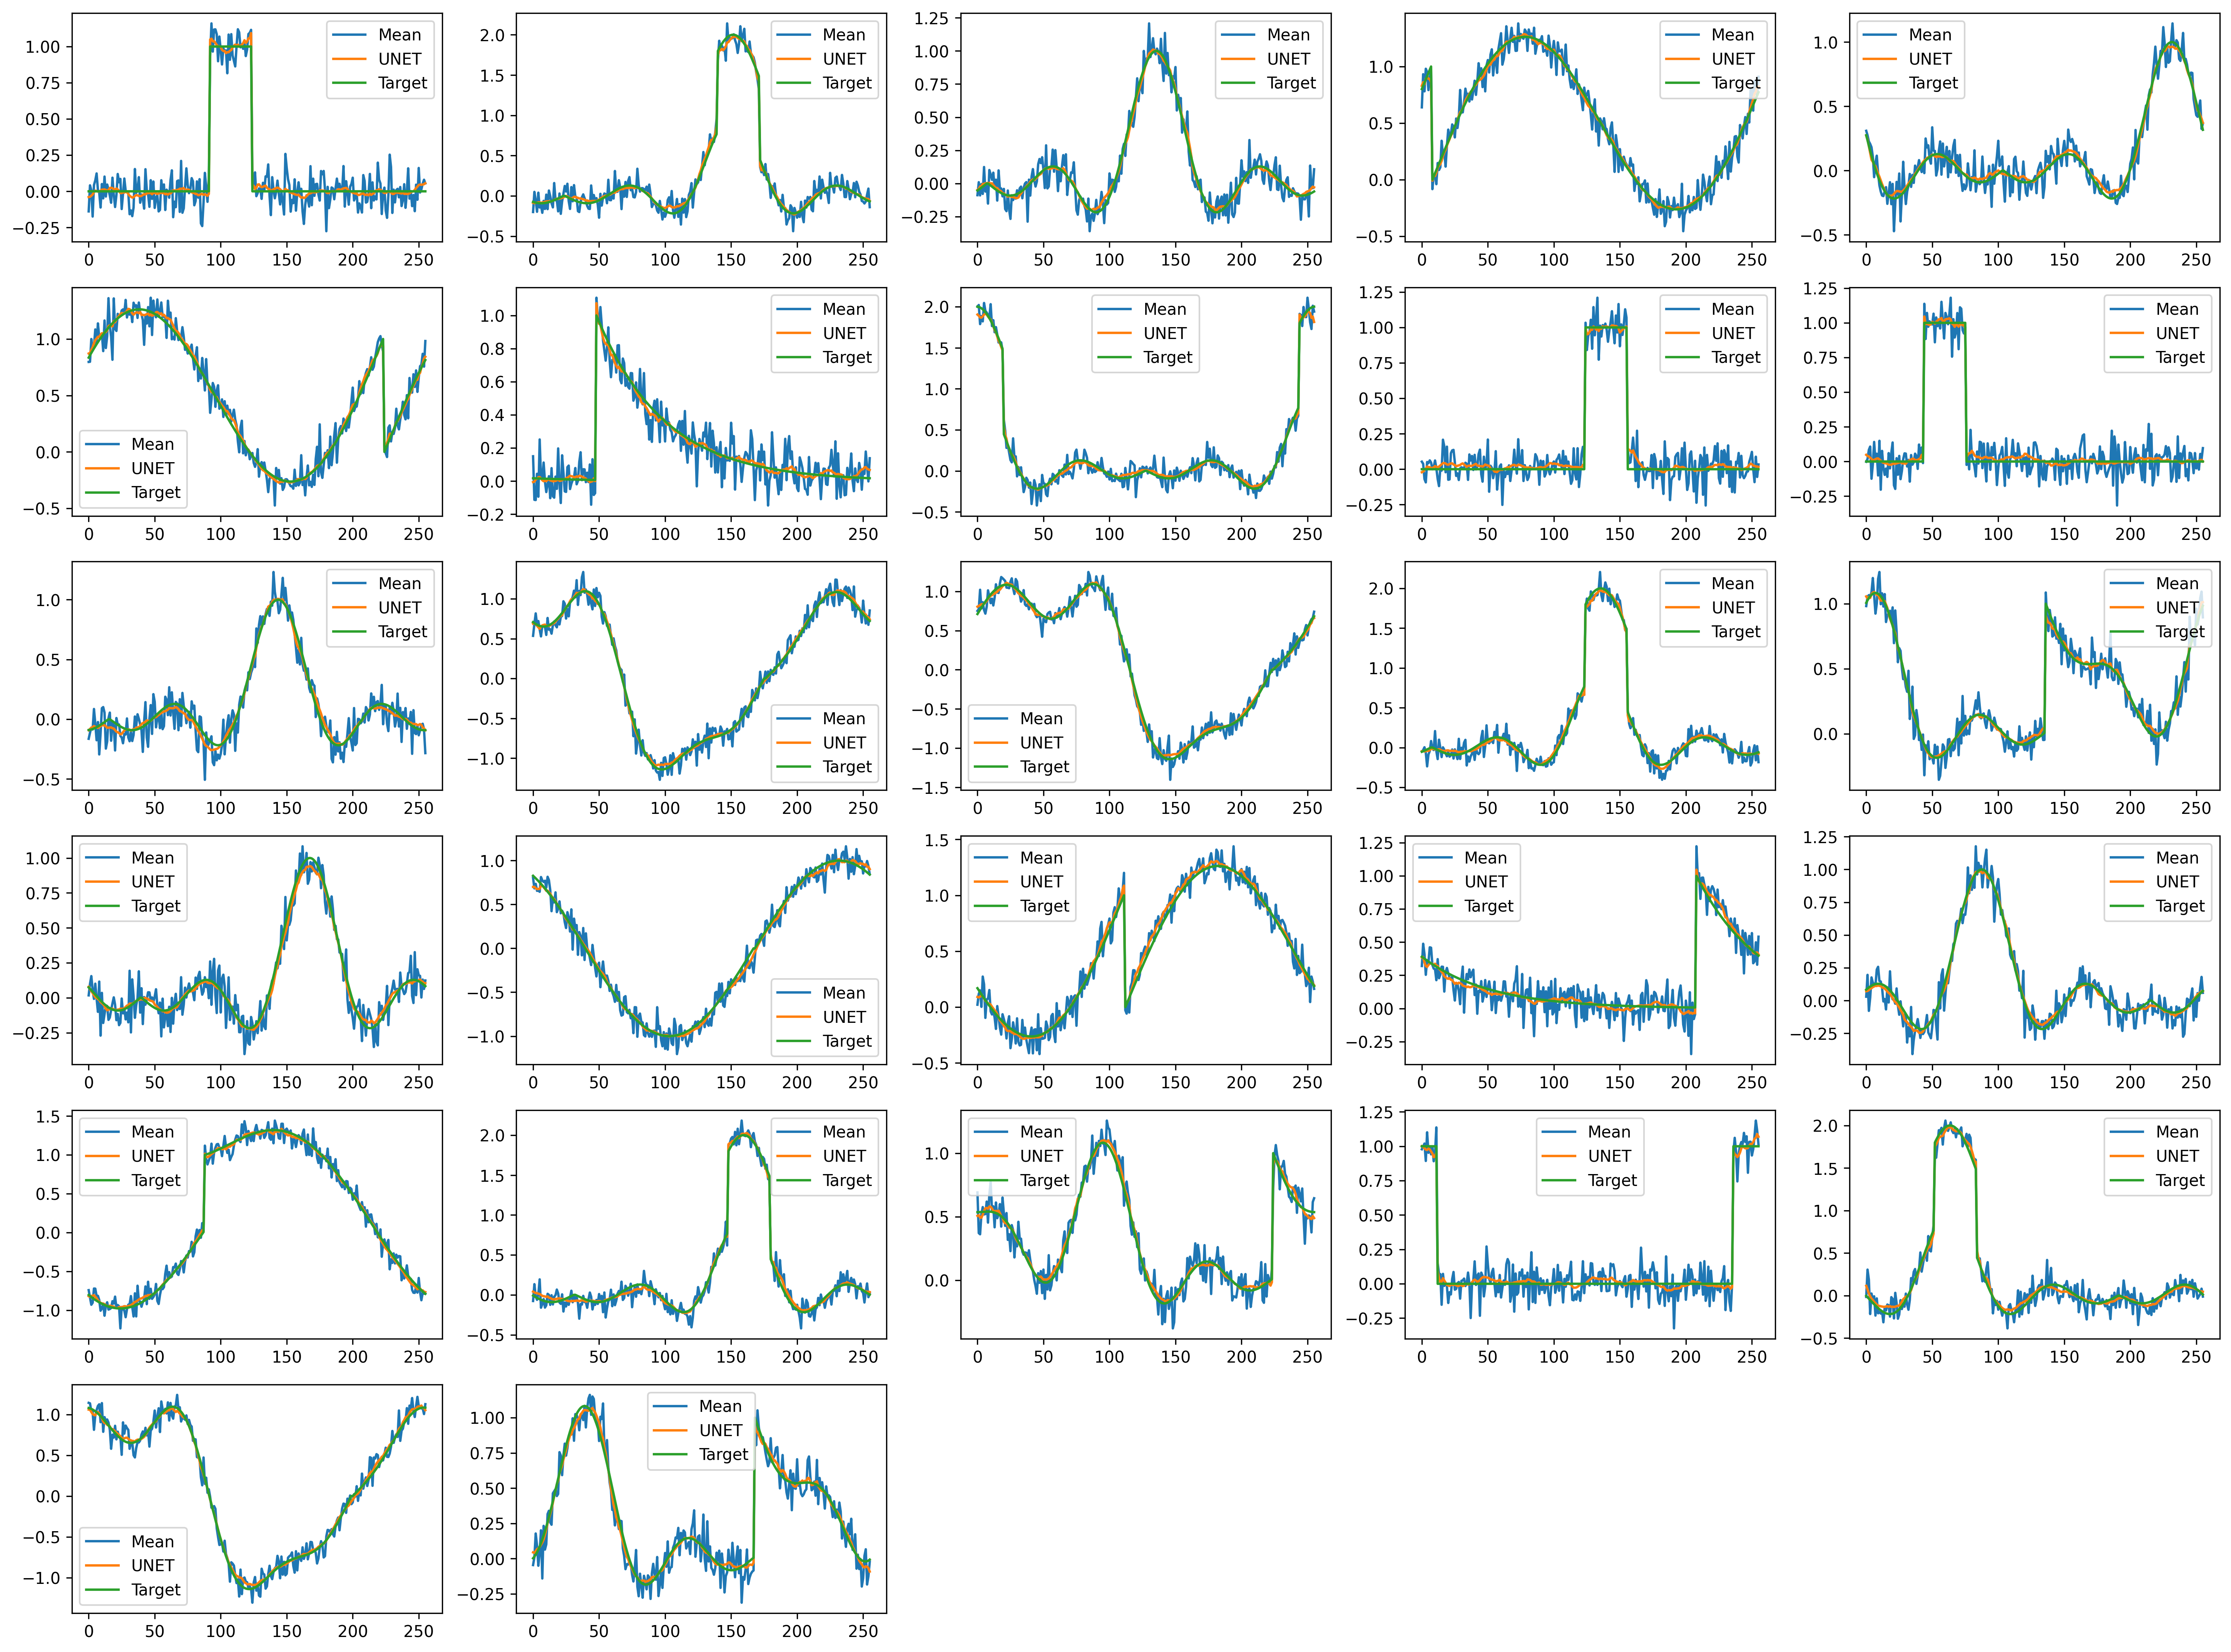

In [18]:
print(Ymean_unscaled.shape)
print(Ypred_unscaled.shape)
print(Y_test.shape)
#Showing results
plt.figure(figsize = (24,18), dpi = 300)
for (ii) in range(27):
    plt.subplot(6,5,ii+1)
    #plt.plot(X_test2[ii,:,0], label = "Noisy")
    plt.plot(Ymean_unscaled[ii], label = "Mean")
    plt.plot(Ypred_unscaled[ii], label = "UNET")
    plt.plot(Y_test[ii], label = "Target")
    plt.legend()
plt.show()